# Average (Dumb) Predictor, SARIMAX

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_dir = "../input/demand-forecasting-kernels-only/"

train_filepath = root_dir + "train.csv"
test_filepath = root_dir + "test.csv"
sample_sub_fp = root_dir + "sample_submission.csv"

In [3]:
train_df = pd.read_csv(train_filepath, low_memory=False, parse_dates=['date'], index_col=['date'])
test_df = pd.read_csv(test_filepath, low_memory=False, parse_dates=['date'], index_col=['date'])
s_df = pd.read_csv(sample_sub_fp)

In [4]:
train_df['day'] = train_df.index.day
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year

train_df = train_df.reset_index()

In [5]:
train_df

,date,store,item,sales,day,month,year
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,2,1,2013
2,2013-01-03,1,1,14,3,1,2013
3,2013-01-04,1,1,13,4,1,2013
4,2013-01-05,1,1,10,5,1,2013
...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017
912996,2017-12-28,10,50,59,28,12,2017
912997,2017-12-29,10,50,74,29,12,2017
912998,2017-12-30,10,50,62,30,12,2017


# General Information

### Train Dataset
   - 5 years from 1/1/2013 (Tuesday) to 31/12/2017 (Saturday)
   - 1826 Contiguous days of sales (no store closure) 
   - 10 stores
   - 50 unique items
   - 500 unique (store-item) pairs (This means every store sells those 50 items)

In [6]:
df = train_df
# number of years
print(df.year.unique())

# number of months
print(df.month.unique())

# number of days - 
print(df.day.unique())

# number of stores
print(df.store.unique())

# number of items
print(df.item.unique())

[2013 2014 2015 2016 2017]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [7]:
df.groupby(['store','item']).size().reset_index().rename(columns={0:'count'})

,store,item,count
0,1,1,1826
1,1,2,1826
2,1,3,1826
3,1,4,1826
4,1,5,1826
...,...,...,...
495,10,46,1826
496,10,47,1826
497,10,48,1826
498,10,49,1826


In [8]:
## Add weekdays, 0: Mon, 1: Tue, ... , 6: Sun
import calendar
df["date"] = df['date'].apply(lambda x: x.date())
df["date"] = df['date'].apply(lambda x: str(x))
df["weekday"] = df["date"].apply(lambda x: calendar.weekday(int(x.split("-")[0]),int(x.split("-")[1]), int(x.split("-")[2])))
df

,date,store,item,sales,day,month,year,weekday
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2
912996,2017-12-28,10,50,59,28,12,2017,3
912997,2017-12-29,10,50,74,29,12,2017,4
912998,2017-12-30,10,50,62,30,12,2017,5


# Descriptive Statistics
 - `sales` column mean & std

In [9]:
df["sales"].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

# Seasonality
Every year, the mean sales follow a pattern, displaying a seasonality trend repeating every year, in an increasing fashion.
- Mean sales increase as the year increases from 2013 to 2017
- Mean sales trend increases from the start of the year (January) and peaks at the month of July before decreasing till December, with the exception of a subtle increase in mean sales between October and November.

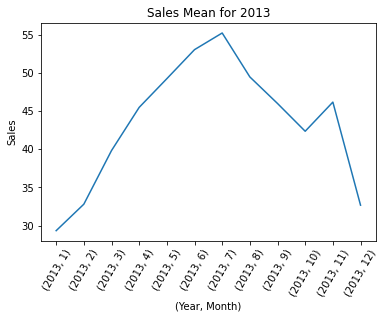

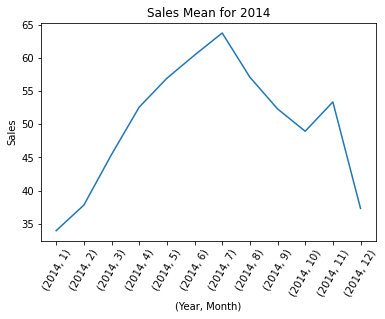

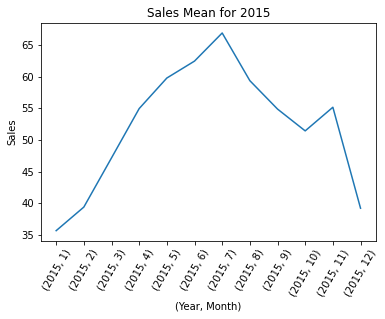

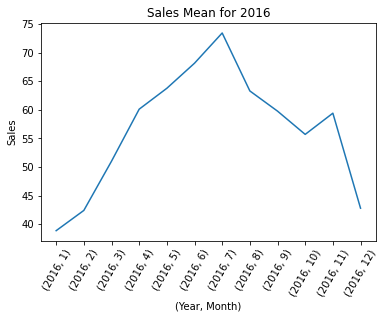

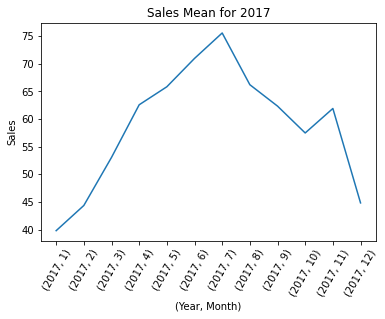

In [10]:
temp_df = df[['year', 'month', 'sales']]

for i in temp_df.year.unique():
    ax = temp_df[temp_df['year'] == i].groupby(['year', 'month']).mean().plot(xticks=range(temp_df.month.nunique()), legend=False)
    ax.set_xticklabels(labels=temp_df[temp_df['year'] == i].groupby(['year', 'month']).mean().index, rotation=60)
    ax.set_title(f'Sales Mean for {i}')
    ax.set_xlabel('(Year, Month)')
    ax.set_ylabel('Sales')

Plotting the sums instead of mean sales yields a similar seasonality trend.

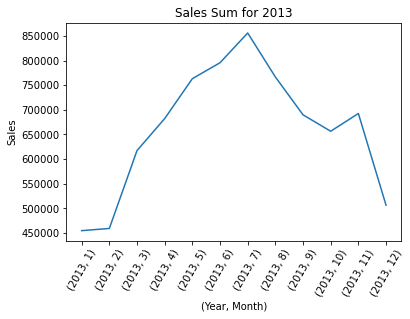

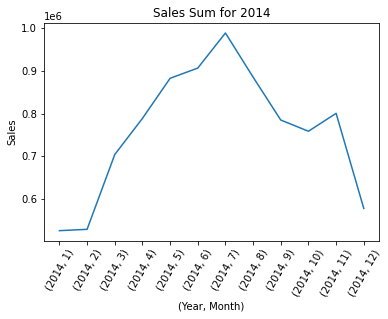

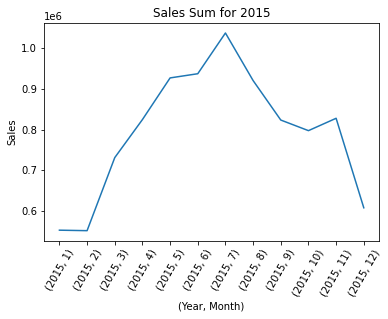

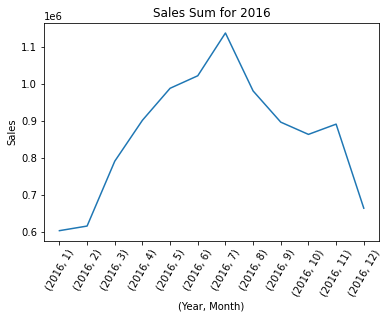

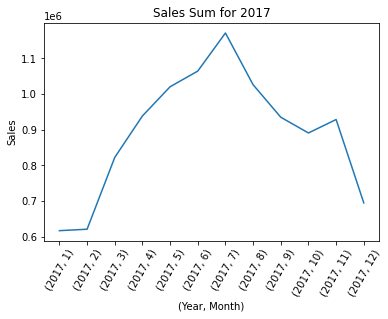

In [11]:
temp_df = df[['year', 'month', 'sales']]

for i in temp_df.year.unique():
    ax = temp_df[temp_df['year'] == i].groupby(['year', 'month']).sum().plot(xticks=range(temp_df.month.nunique()), legend=False)
    ax.set_xticklabels(labels=temp_df[temp_df['year'] == i].groupby(['year', 'month']).sum().index, rotation=60)
    ax.set_title(f'Sales Sum for {i}')
    ax.set_xlabel('(Year, Month)')
    ax.set_ylabel('Sales')

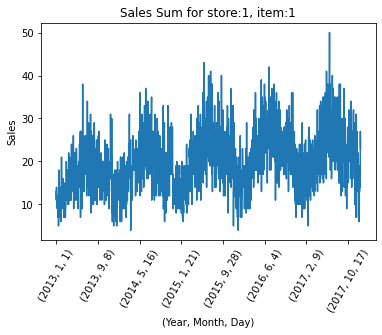

In [12]:
temp_df = df[['year', 'month', 'day', 'sales', 'store', 'item']]

for i in temp_df.store.unique():
    for j in temp_df.item.unique():
        temp_df_si = temp_df[(temp_df['store'] == i) & (temp_df['item'] == j)]
        ax = temp_df_si[['year', 'month', 'day', 'sales']].groupby(['year', 'month', 'day']).sum().plot(legend=False, rot=60)
        ax.set_title(f'Sales Sum for store:{i}, item:{j}')
        ax.set_xlabel('(Year, Month, Day)')
        ax.set_ylabel('Sales')
        break
    break

## Baseline models

Let X be 1 test example of (month, day, store, item)

- If same month, same day, same store, same item, we predict using the average

In [13]:
## Convert test.csv
def add_features(df):
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    
    return df

tdf = add_features(test_df.copy()).reset_index()
tdf["date"] = tdf['date'].apply(lambda x: x.date())
tdf["date"] = tdf['date'].apply(lambda x: str(x))
tdf["weekday"] = tdf['date'].apply(lambda x: calendar.weekday(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])))
tdf

,date,id,store,item,day,month,year,weekday
0,2018-01-01,0,1,1,1,1,2018,0
1,2018-01-02,1,1,1,2,1,2018,1
2,2018-01-03,2,1,1,3,1,2018,2
3,2018-01-04,3,1,1,4,1,2018,3
4,2018-01-05,4,1,1,5,1,2018,4
...,...,...,...,...,...,...,...,...
44995,2018-03-27,44995,10,50,27,3,2018,1
44996,2018-03-28,44996,10,50,28,3,2018,2
44997,2018-03-29,44997,10,50,29,3,2018,3
44998,2018-03-30,44998,10,50,30,3,2018,4


In [14]:
## Drop columns
df_1 = df.copy().drop(columns= ["date","year","weekday"])
df_2 = tdf.copy().drop(columns=["date","year","weekday"])

In [15]:
## Generate Predict Values
df_1 = df_1.groupby(["store", "item","day","month"]).mean().rename(columns={"sales": "predict_sales"}).reset_index()
result = df_2.merge(df_1, how='left', on=["store", "item","day","month"])
result

,id,store,item,day,month,predict_sales
0,0,1,1,1,1,14.6
1,1,1,1,2,1,14.4
2,2,1,1,3,1,12.6
3,3,1,1,4,1,15.0
4,4,1,1,5,1,13.4
...,...,...,...,...,...,...
44995,44995,10,50,27,3,69.8
44996,44996,10,50,28,3,61.2
44997,44997,10,50,29,3,72.6
44998,44998,10,50,30,3,67.8


In [16]:
result = result.drop(columns=["store", "item","day","month"])
result = result.rename(columns={"predict_sales": "sales"})

In [17]:
result.head()

,id,sales
0,0,14.6
1,1,14.4
2,2,12.6
3,3,15.0
4,4,13.4


In [18]:
result.to_csv("./average_predictor.csv", index=False)

Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df1 = df2 = df.copy().drop(columns=["day", "month", "year", "weekday"])

In [20]:
from itertools import product
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import numpy as np

horizon = 90

def predict_SARIMAX(data, start, end):
    model = SARIMAX(data, order=(6, 1, 0), seasonal_order=(1, 0, 0, 7), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(start, end)
    return yhat

pred_values = []
c = 0

for item, store in tqdm(list(product(range(1, 51), range(1, 11)))):
    q = "store == {} and item == {}".format(store, item)
    sales = df1.query(q)["sales"].reset_index(drop=True)
    sales_diff = sales.diff(periods=1).values[1:]
    max_sale_diff = max(sales_diff)
        
    start_datapt = 1
    end_datapt = len(sales) + horizon
    pred_values.extend(predict_SARIMAX(sales, start_datapt, end_datapt)[-horizon:])

#     if(sales == None):
#         print(store, item)
#         break
    
#     if store == 1 and item == 1:
#         fig = plt.figure(figsize=(12,8))
#         ax1 = fig.add_subplot(211)
#         fig = sm.graphics.tsa.plot_acf(sales.values.squeeze(), lags=40, ax=ax1)
#         ax2 = fig.add_subplot(212)
#         fig = sm.graphics.tsa.plot_pacf(sales, lags=40, ax=ax2)

        
#         lag_acf = acf(sales_diff, nlags=40)
#         lag_pacf = pacf(sales_diff, nlags=40, method="ols")
#         plt.figure(figsize = (15,5))
#         plt.subplot(121)
#         plt.stem(lag_acf)
#         plt.axhline(y=0, linestyle="-", color='black')
#         plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle="--", color='grey')
#         plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle="--", color='grey')
#         plt.xlabel("Lag")
#         plt.ylabel("ACF")
#         plt.plot(sales_diff)
#         plt.xlabel("Days")
#         plt.ylabel("Sales")
#         plt.subplot(122)
#         plt.stem(lag_pacf)
#         plt.axhline(y=0, linestyle="-", color='black')
#         plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle="--", color='grey')
#         plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle="--", color='grey')
#         plt.xlabel("Lag")
#         plt.ylabel("PACF")

#         plt.plot(sales, label='sales')
#         plt.plot(pred_values, label='SARIMA Prediction')
#         plt.title(f'Sales for store:{store}, item:{item}')
#         plt.ylabel('Sales Quantity')
#         break

result = pd.DataFrame({"sales": pred_values})

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
result['id'] = [i for i in range(45000)]
result.head()

,sales,id
0,14.146404,0
1,15.771629,1
2,16.009725,2
3,14.667606,3
4,19.904318,4


In [22]:
result = result.reindex(columns=['id', 'sales'])
result.head()

,id,sales
0,0,14.146404
1,1,15.771629
2,2,16.009725
3,3,14.667606
4,4,19.904318


In [23]:
result.to_csv("./submission.csv", index=False)